In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import sys
sys.path.append('..')
import d2lzh_pytorch as d2l

print(torch.__version__)
torch.set_default_tensor_type(torch.FloatTensor)

1.1.0


#### 读取数据

In [2]:
train_data = pd.read_csv('./Datasets/kaggle_house/train.csv')
test_data = pd.read_csv('./Datasets/kaggle_house/test.csv')

In [3]:
train_data.shape
test_data.shape
# 查看前四个样本的前四个和后两个特征及标签
train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]]

,Id,MSSubClass,MSZoning,LotFrontage,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,WD,Normal,208500
1,2,20,RL,80.0,WD,Normal,181500
2,3,60,RL,68.0,WD,Normal,223500
3,4,70,RL,60.0,WD,Abnorml,140000


In [4]:
# 将训练数据和测试数据的79个特征按样本连接
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

#### 数据预处理

- 对连续数据的特征进行标准化：(x-μ)/σ
- 缺失的特征值替换成μ

In [5]:
print(all_features.dtypes)

MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
                  ...   
MiscVal            int64
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
Length: 79, dtype: object


In [6]:
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index # 数值数据的索引
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std())
)
# 标准化后，每个特征的均值变为0，所以可以直接用0来代替缺失值
all_features = all_features.fillna(0)

- 将离散数值转成指示特征
- example: MSZoning: RL, RM 转换成：MSZoning_RL(0), MSZoning_RM(1)

In [7]:
# dummy_na=True将缺失值也当做合法的特征值并为其创建指示特征
all_features = pd.get_dummies(all_features, dummy_na=True)
print(all_features.shape) # 转化后特征数量由79增加到了354
print(all_features.dtypes.index)

(2919, 354)
Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       ...
       'SaleType_Oth', 'SaleType_WD', 'SaleType_nan', 'SaleCondition_Abnorml',
       'SaleCondition_AdjLand', 'SaleCondition_Alloca', 'SaleCondition_Family',
       'SaleCondition_Normal', 'SaleCondition_Partial', 'SaleCondition_nan'],
      dtype='object', length=354)


- 通过values属性得到Numpy格式的数据，并转化成NDArray

In [8]:
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float)
train_labels = torch.tensor(train_data.SalePrice.values, dtype=torch.float).view(-1, 1)

#### 定义模型
- 使用简单的线性回归模型

In [9]:
def get_net(feature_num): 
    net = nn.Linear(feature_num,1)
    for param in net.parameters():
        nn.init.normal_(param, mean=0, std=0.01)
    return net

#### 定义损失函数
- 损失函数使用平方损失函数:
![title](images/平方损失函数.png)

In [10]:
loss = torch.nn.MSELoss() 

- 比赛评价模型指标：对数均方根误差
![title](images/对数均方根误差.png)

In [11]:
def log_rmse(net, features, labels):
    with torch.no_grad():
        # 将小于1的值设成1，是取对数是数值更稳定
        clipped_preds = torch.max(net(features), torch.tensor(1.0))
        rmse = torch.sqrt(2 * loss(clipped_preds.log(), labels.log()).mean())
    return rmse.item()

#### 定义训练函数

In [12]:
def train(net, train_features, train_labels, test_features, test_labels, num_epochs, lr, weight_decay, batch_size):
    train_ls, test_ls = [], []
    dataset = torch.utils.data.TensorDataset(train_features, train_labels)
    train_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)
    optimizer = torch.optim.Adam(params=net.parameters(), lr=lr, weight_decay=weight_decay)
    net = net.float()
    
    for epoch in range(num_epochs):
        for X, y in train_iter:
            l = loss(net(X.float()), y.float())
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

#### 定义K折交叉验证函数

In [13]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j+1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat((X_train, X_part), dim=0)
            y_train = torch.cat((y_train, y_part), dim=0)
            
    return X_train, y_train, X_valid, y_valid

In [14]:
def k_fold(k, X_train, y_train, num_epochs, lr, weight_decay, batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net(X_train.shape[1]) # 创建网络模型
        train_ls, valid_ls = train(net, *data, num_epochs, lr, weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        
        if i == 0:
            d2l.semilogy(range(1, num_epochs + 1), train_ls,
                         'epochs', 'rmse',
                         range(1, num_epochs + 1), valid_ls,
                         ['train', 'valid'])
        print('fold %d, train rmse %f, valid rmse %f' % (i, train_ls[-1], valid_ls[-1]))
    return train_l_sum / k, valid_l_sum / k

#### 模型选择
- 使用一组未经调优的超参数并计算交叉验证误差
- 并根据结果更改超参数尽可能减小平均测试误差
- 来选择一组最优的超参数

fold 0, train rmse 0.239165, valid rmse 0.221005
fold 1, train rmse 0.228969, valid rmse 0.265795
fold 2, train rmse 0.231513, valid rmse 0.238231
fold 3, train rmse 0.237626, valid rmse 0.218683
fold 4, train rmse 0.231476, valid rmse 0.259096
5-fold validatoin: avg train rmse 0.233750, avg valid rmse 0.240562


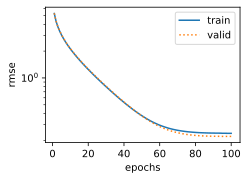

In [16]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr, weight_decay, batch_size)
print("%d-fold validatoin: avg train rmse %f, avg valid rmse %f" % (k, train_l, valid_l))

#### 预测
- 选择最优模型后，使用完整的训练集来重新训练模型
- 保存预测结果

In [20]:
def train_and_pred(train_features, test_features, train_labels, test_data, num_epochs, lr, weight_decay, batch_size):
    net = get_net(train_features.shape[1])
    train_ls, _ = train(net, train_features, train_labels, None, None, num_epochs, lr, weight_decay, batch_size)
    d2l.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'rmse')
    print('train rmse %f' % train_ls[-1])
    preds = net(test_features).detach().numpy()
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('./Datasets/kaggle_house/submission.csv', index=False)

train rmse 0.229831


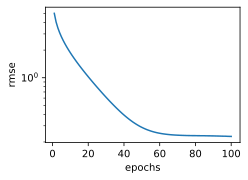

In [21]:
train_and_pred(train_features, test_features, train_labels, test_data, num_epochs, lr, weight_decay, batch_size)